# 4. Deep Neural Network with Keras

In [134]:
#Install Dependencies

import time
import datetime
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import keras
import pandas_gbq
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from Functions.confusion_matrix import plot_confusion_matrix
import math
import matplotlib.pyplot as plt
from datetime import datetime
from keras.callbacks import TensorBoard

In [76]:
#Call BigQuery

"""
1st - Call bigquery and create new dataset then tables
2nd - Upload jsons to bigquery
3rd - Query the data tables to pull in the necessary information
"""

#1 Call bigquery and create new dataset then tables

#Call BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account

#credentials 
credentials = service_account.Credentials.from_service_account_file(
    '*****_credentials.json')

#Project id name
project_id = '*****'

#create the client
client = bigquery.Client(credentials= credentials,project=project_id)

In [77]:
#Import data
sql = """
    SELECT A.sku, A.inventory, A.pieces_past_due, A.min_rec_stock,
      B.sales_1_mon, B.sales_3_mon, B.sales_6_mon,
      C.forecast_3_mon, C.forecast_6_mon,
      D.lead_time, D.potential_issue,
      E.backorder
FROM `backorder_chain_example.inventory` as A
INNER JOIN  `backorder_chain_example.sales`  as B
ON A.sku = B.sku
INNER JOIN `backorder_chain_example.forecast` as C
ON A.sku = C.sku
INNER JOIN `backorder_chain_example.inventory_ordering` as D
ON A.sku = D.sku
INNER JOIN `backorder_chain_example.backorder` as E
ON A.sku = E.sku
  """
start = time.time()

#We will imput the data from the query and re-create the dataframe we created earlier
df = pd.read_gbq(sql, dialect='standard', project_id=project_id)

end = time.time()
print("Query time was " + str(np.round((end-start)/60,2)) + " minutes")

Query time was 2.79 minutes


In [142]:
#Define X and y
y = df['backorder']
X = df.drop(columns=['backorder'])
y_classes = np.array(['no_backorder', 'Backorder'])

#Get training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Get test and dev sets
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 1)

#Drop sku
X_train = X_train.drop(columns=['sku'])

#Using smote to rebalance data
from collections import Counter

#Import oversampling 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

#Resample
current_count = Counter(y_train)
print(f"Unbalanced count is {current_count}")

X_res, y_res = sm.fit_resample(X_train, y_train)

resampled_count = Counter(y_res)
print(f"Rebalanced count is {resampled_count}")

Unbalanced count is Counter({0: 1140175, 1: 59825})
Rebalanced count is Counter({0: 1140175, 1: 1140175})


In [147]:
X_shape = X_res.shape
y_shape = y_res.shape
print(f"X_res shape is {X_shape}")
print(f"y_res shape is {y_shape}")

X_res shape is (2280350, 10)
y_res shape is (2280350,)


In [148]:
#Normalize data

def norm(X_train):
    mean_val = np.mean(X_train, axis=0)
    train_max = np.max(X_train, axis=0)
    train_min = np.min(X_train,axis=0)
    
    train_norm = np.asanyarray((X_train-mean_val)/(train_max - train_min))
    
    return train_norm

In [149]:
X_train_norm = norm(X_res)
assert X_train_norm.shape == X_res.shape

In [150]:
#Select 200K records and exclude sku
X_train_norm2 = X_train_norm[:200000,]
y_train2 = y_res[:200000,]

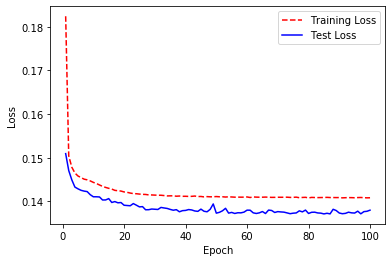

In [151]:
#Keras model

"""
This section builds a DNN using Keras and Tensorflow
- Input layer will have shape of (10,10) - 10 nodes and 10 inputs
- Hidden layer will have shape of (4,10) - 4 nodes and 10 inputs
- Output layer will have shape of (1,4) - 1 node with 4 inputs

- We will specify a Relu activation in the first two layers followed by sigmoid
in the last in order to predict a probability between 0 and 1 (for binary classification).
- We will also use binary cross entropy because this is a binary classification problem along with ADAM algo for gradient descent.

After compiling and fitting the model, we will make class predictions, a confusion matrix 
and a list of the expected probability for each item on backorder.

"""

logdir="Logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

input_dim_ = X_train_norm.shape[1]

model = Sequential()
model.add(Dense(10, input_dim = input_dim_, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Compile keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit Model
model = model.fit(X_train_norm2, y_train2, verbose=0,validation_split= .05, epochs=100, batch_size=64, callbacks=[tensorboard_callback])

# Get training and test loss histories
training_loss = np.asanyarray(model.history['loss'])
test_loss = np.asanyarray(model.history['val_loss'])

# Create count of the number of epochs
epoch_count = np.asanyarray(range(1, len(training_loss) + 1))

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [152]:
#Sample a subset of the data and remove sku
X_test_drop_sku = X_test.drop(columns=['sku'])

#Normalize X_test data
X_test_norm=norm(X_test_drop_sku)

X_test_norm = X_test_norm[:10000,]
y_test = y_test[:10000,]

print(X_test_norm.shape)
print(y_test.shape)

(10000, 10)
(10000,)


In [153]:
y_test_pred =model.model.predict_classes(X_test_norm)

Normalized confusion matrix
[[0.96830912 0.03169088]
 [0.61553785 0.38446215]]


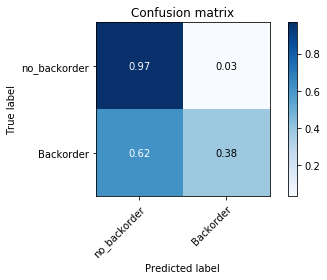

In [154]:
#Class labels
y_classes = np.array(['no_backorder', 'Backorder'])

# Plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=y_classes, normalize=True, title='Confusion matrix')

plt.show()

### The current network predicts backorder with 38% accuracy with a first pass through using only 200K individual cases. The full run on a GCP-VM with GPU support puts the accuracy arround 80%.
Things we can do to improve accuracy of the dev set:
- Train with all data
- Change network architecture
- Change batch size, batch normalization
- Add drop out
- Try different gradient descent algos

### What if we wanted to know the probability?
- With limited resources, we will only be able to prioritize a select few items per day to focus on improving.
- Instead of class prediction, we can return the estimated probability of an item going on backorder.

In [242]:
#Get predictions
y_test_prob =model.model.predict(X_test_norm).ravel()

#Get skus
sku = X_test['sku'][:10000]

#Adding random day for later visualization
day = [np.random.randint(1,31) for i in range(0,len(sku))]

#Combine into dataframe
inventory_prob = pd.DataFrame({'day':day, 
                               'sku':sku, 
                               'prob_backorder':y_test_prob}).sort_values(['day', 'prob_backorder'], ascending=[True, False])

In [243]:
inventory_prob.head(20)

,day,sku,prob_backorder
1390734,1,1198542,0.866655
55831,1,1347950,0.796215
415597,1,1252976,0.776303
1050669,1,1176770,0.741105
796204,1,597833,0.703552
627242,1,1259093,0.685835
109170,1,509956,0.631692
893454,1,835355,0.630772
566015,1,447447,0.585249
346654,1,1142325,0.571224
